In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import requests

from math import sqrt
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from matplotlib import colormaps

from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite

from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# 41589: EUTELSAT 117B
# 38991: Star One C3
# 41886: GOES-16

def get_TLE_dataframe(satellite_id, start_jd, end_jd):
    '''
    Use the Satchecker service to build a dataframe with historical TLEs for
    a satellite with a NORAD ID over a Julian Date Range.

    Useful NORAD satellite IDs include.

    41589: EUTELSAT 117B
    38991: Star One C3
    41886: GOES-16
    '''

    url = 'https://satchecker.cps.iau.org/tools/get-tle-data/'
    params = {'id': satellite_id,
            'id_type': 'catalog',
            'start_date_jd': start_jd,
            'end_date_jd': end_jd
            }
    r = requests.get(url, params=params)
    df = pd.DataFrame(r.json())

    df['epoch'] = pd.to_datetime(df['epoch'], utc=True)
    df.set_index('epoch', inplace=True)

    # Get rid of duplicate TLEs
    df = df[~df.index.duplicated(keep='first')]

    return df

def get_matching_tle(df, tai_time):
    '''
    Return the closest matching TLE matching in time
    '''
    
    # Convert to datetime format for pandas
    exp_time = pd.to_datetime([tai_time.utc.isot], utc=True)
    epoch_index = df.index.get_indexer(exp_time, method='nearest')

    best_tle_time = df.index[epoch_index]
    tle_delay = (best_tle_time - exp_time)/pd.Timedelta(hours=1)

    sat_name = df.satellite_name.iloc[epoch_index]
    TLE1 = df.tle_line1.iloc[epoch_index]
    TLE2 = df.tle_line2.iloc[epoch_index]

    return sat_name, best_tle_time, tle_delay, TLE1, TLE2

def calculate_tle_position(satellite_tle, Earth_location, timescale, tai_time, time_offset=0):
    '''
    Calculate the position of a satellite using the publicly available TLEs
    '''
   
    # Add a delta time to the header time if necessary.
    tai_time = tai_time + timedelta(seconds=time_offset)

    sat_name, best_tle_time, tle_delay, tle_line1, tle_line2 = get_matching_tle(satellite_tle, tai_time)
    satellite = EarthSatellite(tle_line1.iloc[0], tle_line2.iloc[0], sat_name.iloc[0], timescale)

    skyfield_time = timescale.from_astropy(tai_time)
    sat_ra, sat_dec, sat_dist = (satellite - Earth_location).at(skyfield_time).radec()
    sat_height = wgs84.height_of(satellite.at(skyfield_time)).m
    
    return (tai_time, sat_name.iloc[0], best_tle_time[0], tle_delay[0], tle_line1.iloc[0], tle_line2.iloc[0], 
            sat_ra._degrees, sat_dec.degrees, sat_height)

eutel_tle =  get_TLE_dataframe(41589, 2460643, 2460653 ) # 11/28 - 12/08

In [3]:
# Read in WAAS position data from the FAA web page

waas = pd.read_csv('/sdf/home/c/cwalter/waas.txt', parse_dates=[0], header=None, names=['date','lat', 'lon'])
waas.set_index('date', inplace=True)

#waas.plot.scatter('lon', 'lat', s=.01)


In [4]:
def get_interpolated_waas(df, tai_time, resample_period='30.0s'):

    stop_time = tai_time + 15.0*u.min
    start_time = tai_time - 15.0*u.min
    df_timewindow = df.loc[start_time.utc.iso:stop_time.utc.iso]
    
    df_resampled = df_timewindow.resample(resample_period).asfreq()
    combined = pd.concat([df_resampled, df_timewindow]).sort_index()
    combined.interpolate(method='cubicspline', inplace=True)

    return df_timewindow, combined

def calculate_waas_position(interpolated, tai_time, sat_height, time_offset=0, orbit_offset_1=0.0, orbit_offset_2=0):

    # Add a delta time to the header time if necessary.
    tai_time = tai_time + timedelta(seconds=time_offset)

    find_time = pd.to_datetime(tai_time.utc.isot, utc=True)
    found_index = interpolated.index.get_indexer([find_time], method='nearest')[0]

    found_time = interpolated.index[found_index]
    found_lon = interpolated.iloc[found_index].lon
    found_lat =  interpolated.iloc[found_index].lat
    
    # Oh man, we need a better way to do this!
    month = tai_time.ymdhms['month']
    if month == 11:
        orbit_offset = orbit_offset_1
    elif month == 12:
        orbit_offset = orbit_offset_2

    height_now = sat_height + orbit_offset
    
    ground = EarthLocation.of_site('Rubin Observatory')
    satelite = EarthLocation.from_geodetic(lat=found_lat, lon=found_lon, height=height_now)
    found_altaz = satelite.get_itrs(obstime=tai_time, location=ground).transform_to(AltAz(obstime=tai_time, location=ground))

    altaz_coordinate = SkyCoord(alt = found_altaz.alt, az = found_altaz.az, obstime=tai_time, location=ground, frame='altaz')
    fk5 = altaz_coordinate.transform_to('fk5')
    
    return found_time, found_lat, found_lon, fk5.ra.deg, fk5.dec.deg

#tai_time = Time("2024-12-08T08:07:47.785", scale='tai')
#df_timewindow, interpolated = get_interpolated_waas(waas, tai_time, '.001s')
#found_time, eutel_lat, eutel_lon, eutel_alt, eutel_az = get_waas_position(interpolated, tai_time)
#print(found_time, eutel_lat, eutel_lon, eutel_alt, eutel_az)
#interpolated.plot.scatter('lon', 'lat', s=.01)

In [5]:
# Get hand scanned satellite data from processed fits files

#satellite_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRs-6gh1dIAjqTUdN-UOpQmaohx1U3ecO8vrb2EHUbBkoPeV14XWbtPW60-vy7cQt1Wcf1022tSo61J/pub?gid=1240073687&single=true&output=csv'
satellite_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRs-6gh1dIAjqTUdN-UOpQmaohx1U3ecO8vrb2EHUbBkoPeV14XWbtPW60-vy7cQt1Wcf1022tSo61J/pub?gid=1240073687&single=true&output=csv'
satellite_df = pd.read_csv(satellite_data)
satellite_df = satellite_df.set_index(['obsid', 'satellite'])

satellite_df = satellite_df.drop('Notes', axis=1)
satellite_df = satellite_df.dropna(how='all')
satellite_df

,,RA_Start,DEC_Start,Error_Start,RA_End,DEC_End,Error_End
obsid,satellite,,,,,,
CC_O_20241129_000237_R22_S21,EUTE 117W B,35.166472,4.626702,0.522,NaN,NaN,NaN
CC_O_20241129_000238_R22_S22,EUTE 117W B,35.232824,4.626801,0.347,NaN,NaN,NaN
CC_O_20241129_000239_R22_S22,EUTE 117W B,35.299805,4.626900,0.581,NaN,NaN,NaN
CC_O_20241129_000240_R22_S22,EUTE 117W B,35.365886,4.627031,0.506,NaN,NaN,NaN
CC_O_20241129_000246_R22_S11,EUTE 117W B,35.971827,4.627898,0.364,NaN,NaN,NaN
CC_O_20241129_000247_R22_S21,EUTE 117W B,36.038466,4.627908,0.514,NaN,NaN,NaN
CC_O_20241129_000249_R22_S22,EUTE 117W B,36.171805,4.628094,0.592,NaN,NaN,NaN
CC_O_20241129_000250_R22_S22,EUTE 117W B,36.238099,4.628133,0.679,NaN,NaN,NaN
CC_O_20241207_000549_R22_S21,EUTE 117W B,76.045773,4.696779,1.081,NaN,NaN,NaN


In [6]:
# Read metadata from processed FITS files and build a dataframe

# Set the location of the observatory 
rubin_obs = EarthLocation.of_site('Rubin Observatory')
Rubin= wgs84.latlon(rubin_obs.lat.deg, rubin_obs.lon.deg, rubin_obs.height.value)

timescale = load.timescale()
records_list = []

for entry in sorted(os.scandir('/sdf/home/c/cwalter/processed-fits'), key=lambda x: x.name):
    with fits.open(entry.path) as hdu_list: 

        hdu = hdu_list[0]
        obs_id = hdu.header['OBSID']+'_'+ hdu.header['RAFTBAY'] +'_'+ hdu.header['CCDSLOT']

        tai_obs_date = Time(hdu.header['DATE-BEG'], scale='tai')

        # Get TLE Info
        position_tuple = calculate_tle_position(eutel_tle, Rubin, timescale, tai_obs_date, time_offset=0)
        
        # Get WAAS Info
        df_timewindow, interpolated = get_interpolated_waas(waas, tai_obs_date, '1s')
        waas_tuple = calculate_waas_position(interpolated, tai_obs_date, sat_height=position_tuple[8])

        records_list.append([obs_id] + [*position_tuple] + [*waas_tuple])

df = pd.DataFrame(records_list, columns=['obsid','TAI_time', 'satellite', 
                                         'best TLE', 'tle_delay', 'tle_line1', 'tle_line2',
                                         'tle_RA', 'tle_DEC', 'TLE_height',
                                         'waas_time', 'wass_lat', 'waas_lon', 'waas_RA', 'waas_DEC'])
df = df.merge(satellite_df, how='inner', on=['obsid','satellite'])

df['mjd'] = df.TAI_time.apply(lambda x: x.utc.mjd - 60640)
df[['obsid', 'mjd', 'tle_delay', 'waas_RA', 'waas_DEC', 'TLE_height','RA_Start', 'DEC_Start']]


,obsid,mjd,tle_delay,waas_RA,waas_DEC,TLE_height,RA_Start,DEC_Start
0,CC_O_20241129_000237_R22_S21,4.246760,17.916655,35.166282,4.626604,3.578702e+07,35.166472,4.626702
1,CC_O_20241129_000238_R22_S22,4.246944,17.912227,35.232869,4.626694,3.578702e+07,35.232824,4.626801
2,CC_O_20241129_000239_R22_S22,4.247129,17.907799,35.299464,4.626785,3.578702e+07,35.299805,4.626900
3,CC_O_20241129_000240_R22_S22,4.247313,17.903372,35.366038,4.626876,3.578702e+07,35.365886,4.627031
4,CC_O_20241129_000246_R22_S11,4.248991,17.863096,35.971726,4.627708,3.578702e+07,35.971827,4.627898
5,CC_O_20241129_000247_R22_S21,4.249176,17.858668,36.038309,4.627801,3.578702e+07,36.038466,4.627908
6,CC_O_20241129_000249_R22_S22,4.249545,17.849809,36.171533,4.627986,3.578702e+07,36.171805,4.628094
7,CC_O_20241129_000250_R22_S22,4.249729,17.845382,36.238108,4.628078,3.578702e+07,36.238099,4.628133
8,CC_O_20241207_000549_R22_S21,12.338163,-3.904239,76.045848,4.696519,3.578866e+07,76.045773,4.696779
9,CC_O_20241207_000550_R22_S22,12.338319,-3.907996,76.102348,4.696653,3.578866e+07,76.102652,4.696767


In [7]:
EUTEL_TLE = df.assign(delta_ra = lambda x: (x.RA_Start - x.tle_RA)*3600) \
       .assign(delta_dec = lambda x: (x.DEC_Start - x.tle_DEC)*3600) \
       .assign(abs_tle_delay = lambda x: abs(x.tle_delay)) \
       .assign(abs_delta_ra = lambda x: abs(x.delta_ra)) \
       .assign(abs_delta_dec = lambda x: abs(x.delta_dec)) 


EUTEL_WAAS = df.assign(delta_ra = lambda x: (x.RA_Start - x.waas_RA)*3600) \
       .assign(delta_dec = lambda x: (x.DEC_Start - x.waas_DEC)*3600) \
       .assign(abs_tle_delay = lambda x: abs(x.tle_delay)) \
       .assign(abs_delta_ra = lambda x: abs(x.delta_ra)) \
       .assign(abs_delta_dec = lambda x: abs(x.delta_dec)) #\

Text(0, 0.5, 'Absolute TLE Time Delay (hours)')

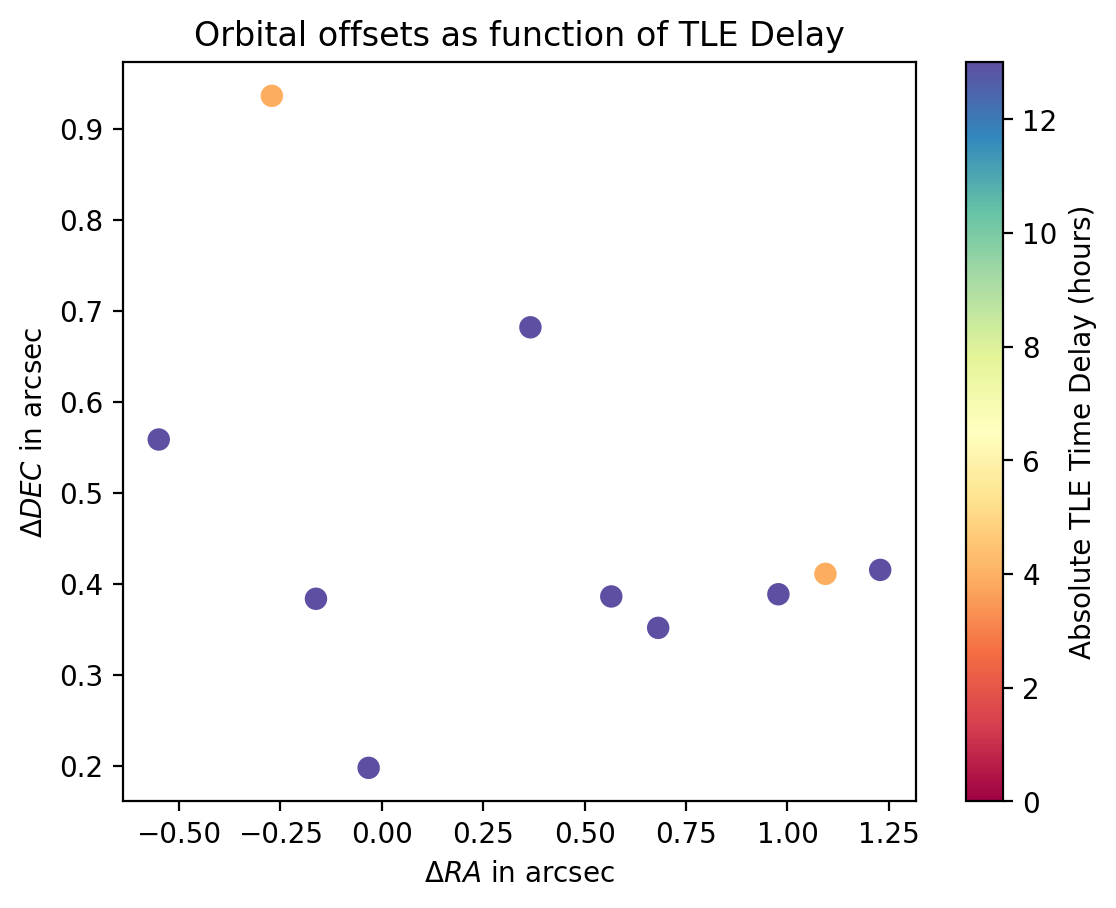

In [8]:
colormap = colormaps['Spectral']
norm = colors.Normalize(vmin=0, vmax=13)
#norm = colors.Normalize(vmin=4.246, vmax=4.2498)

EUTEL_WAAS.plot.scatter('delta_ra', 'delta_dec', marker='o', s=50, c='abs_tle_delay', norm=norm, cmap=colormap)
#EUTEL_WAAS.plot.scatter('delta_ra', 'delta_dec', s='Error_Start', facecolors='none', edgecolors='r')
#EUTEL_WAAS.plot.scatter('delta_ra', 'delta_dec', marker='o', s=50, c='mjd', norm=norm, cmap=colormap)

plt.title('Orbital offsets as function of TLE Delay')
plt.xlabel('$\Delta RA$ in arcsec')
plt.ylabel('$\Delta DEC$ in arcsec')

colorbar_axis = plt.gcf().get_axes()[1]
colorbar_axis.set_ylabel('Absolute TLE Time Delay (hours)')

STD of delta_RA on 11/29 is 0.601


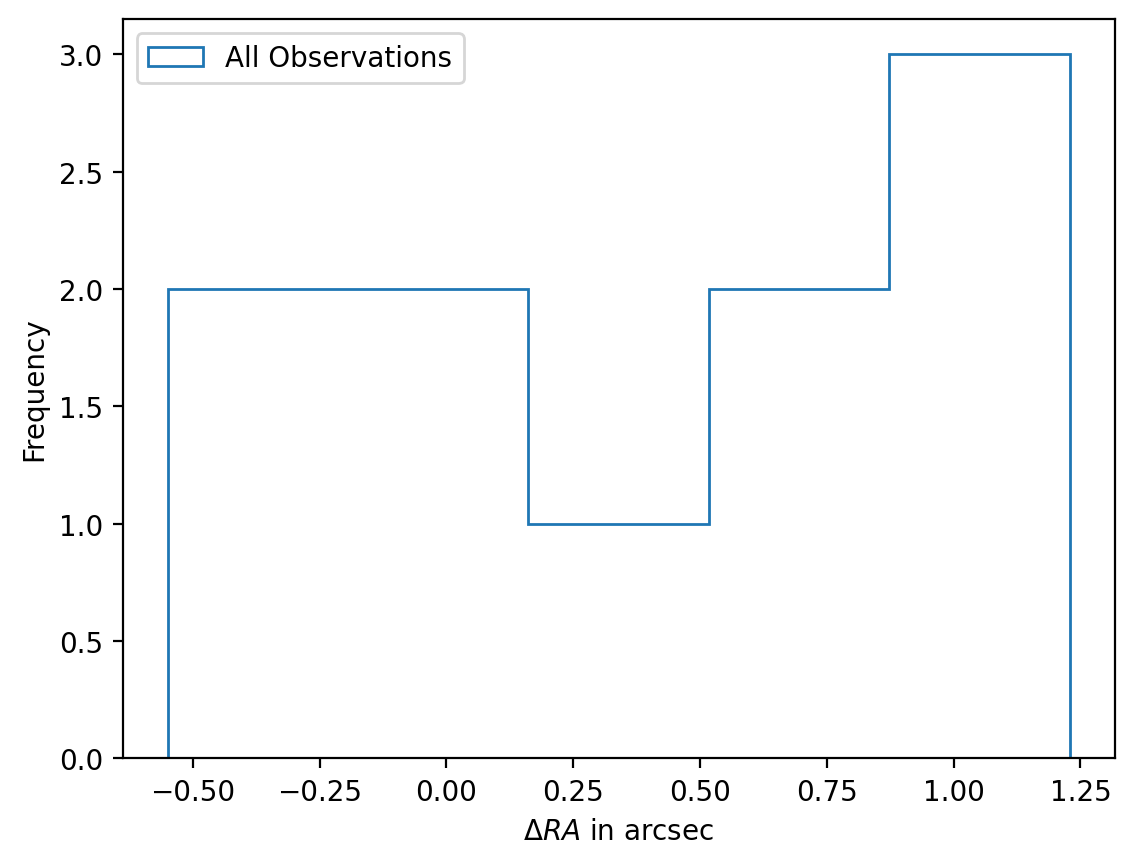

In [9]:
# Look at the distribution of delta_ras

EUTEL_WAAS.delta_ra.plot.hist(bins=5, histtype='step', label='All Observations')

plt.xlabel('$\Delta RA$ in arcsec')
plt.legend(fontsize=10);

print(f'STD of delta_RA on 11/29 is {EUTEL_WAAS.delta_ra[:8].std():4.3f}')

In [10]:
# Calculate the mean errors and the start error positions I measured

print(f'EUTEL: \t {EUTEL_WAAS.delta_ra.mean():4.2f} (+-{EUTEL_WAAS.delta_ra.std():4.2f}) +- {EUTEL_WAAS.Error_Start.mean():4.2f}')

EUTEL: 	 0.39 (+-0.62) +- 0.77


In [11]:
# Calculate the average error in RA but weight the entires by my measured errors 
# on the start positions.
#
# See https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy

values = EUTEL_WAAS.delta_ra
weights = EUTEL_WAAS.Error_Start
weighted_avg = np.average(values, weights=weights)
weighted_std = sqrt(np.average((values-weighted_avg)**2, weights=weights))

print('Rough guess on precision:')
print(f'Weighted averages: {weighted_avg:4.2f}" +- {weighted_std:4.2f}"')
print(f'In milliseconds: {weighted_avg/15*1000:4.2f} ms +- {weighted_std/15*1000:4.2f} ms')
print(f'In milliseconds scaled by sqrt(18): {weighted_avg/15*1000:4.2f} ms +- {weighted_std/15*1000/sqrt(18):4.2f} ms')

Rough guess on precision:
Weighted averages: 0.55" +- 0.61"
In milliseconds: 36.35 ms +- 40.79 ms
In milliseconds scaled by sqrt(18): 36.35 ms +- 9.61 ms


In [12]:
# Needs external global data frames defined:
#   eutel_tle 
#   waas

def calculate_position_df(data_frame, Earth_location, timescale, tai_vector, time_offset, orbit_offset_1, orbit_offset_2):  
    
    sat_ra = np.zeros(len(tai_vector))
    sat_dec = np.zeros(len(tai_vector))
    
    # For each satellite and TLE find the position
    data_frame = data_frame.reset_index()  # make sure indexes pair with number of rows
    for i, row in data_frame.iterrows():
        
        # Get TLE Info
        position_tuple = calculate_tle_position(eutel_tle, Rubin, timescale, tai_vector[i], time_offset=time_offset)
            
        # Get WAAS Info
        df_timewindow, interpolated = get_interpolated_waas(waas, tai_vector[i], '1s')
        waas_tuple = calculate_waas_position(interpolated, tai_vector[i], sat_height=position_tuple[8], 
                                             time_offset=time_offset, 
                                             orbit_offset_1=orbit_offset_1, orbit_offset_2=orbit_offset_2)

        sat_ra[i], sat_dec[i] = waas_tuple[3], waas_tuple[4]

    return sat_ra

def pdf(modified_julian_dates, time_offset=0, orbit_offset_1=0, orbit_offset_2=0):

    # Turn the MJD float back into a TAI Time item (seems to be good to 1e-12 seconds)
    tai_vector = [Time(item, format='mjd', scale='tai') for item in modified_julian_dates]
    sat_ra =  calculate_position_df(df, Rubin, timescale, tai_vector, time_offset, orbit_offset_1, orbit_offset_2)
    
    return sat_ra

In [13]:
#df = df[:8]

# The PDF function requires a float.  So turn the TAI time into MJD
mjds = [item.mjd for item in df.TAI_time]

df['calc_ra'] = pdf(mjds, time_offset = 0.0, orbit_offset_1=0.0, orbit_offset_2=0)
df[['obsid','tle_delay','waas_RA', 'waas_DEC', 'TLE_height','RA_Start', 'DEC_Start', 'calc_ra']]

,obsid,tle_delay,waas_RA,waas_DEC,TLE_height,RA_Start,DEC_Start,calc_ra
0,CC_O_20241129_000237_R22_S21,17.916655,35.166282,4.626604,3.578702e+07,35.166472,4.626702,35.166282
1,CC_O_20241129_000238_R22_S22,17.912227,35.232869,4.626694,3.578702e+07,35.232824,4.626801,35.232869
2,CC_O_20241129_000239_R22_S22,17.907799,35.299464,4.626785,3.578702e+07,35.299805,4.626900,35.299464
3,CC_O_20241129_000240_R22_S22,17.903372,35.366038,4.626876,3.578702e+07,35.365886,4.627031,35.366038
4,CC_O_20241129_000246_R22_S11,17.863096,35.971726,4.627708,3.578702e+07,35.971827,4.627898,35.971726
5,CC_O_20241129_000247_R22_S21,17.858668,36.038309,4.627801,3.578702e+07,36.038466,4.627908,36.038309
6,CC_O_20241129_000249_R22_S22,17.849809,36.171533,4.627986,3.578702e+07,36.171805,4.628094,36.171533
7,CC_O_20241129_000250_R22_S22,17.845382,36.238108,4.628078,3.578702e+07,36.238099,4.628133,36.238108
8,CC_O_20241207_000549_R22_S21,-3.904239,76.045848,4.696519,3.578866e+07,76.045773,4.696779,76.045848
9,CC_O_20241207_000550_R22_S22,-3.907996,76.102348,4.696653,3.578866e+07,76.102652,4.696767,76.102348


In [14]:
from iminuit import Minuit
from iminuit.cost import LeastSquares, NormalConstraint

def viz(args):
    plt.hist((measured_ra - pdf(times, 0, 0))*3600, bins=5, histtype='step')
    plt.hist((measured_ra - pdf(times, *args))*3600, bins=5, histtype='step')

times = [item.mjd for item in df.TAI_time]
measured_ra = df.RA_Start.values
error_ra = df.Error_Start.values/3600

least_squares = LeastSquares(times, measured_ra, error_ra, pdf) 
constraint_1 = NormalConstraint("orbit_offset_1", 0.0, 230.0)
constraint_2 = NormalConstraint("orbit_offset_2", 0.0, 230.0)
cost_sum = least_squares + constraint_1 + constraint_2
least_squares.visualize = viz
least_squares.verbose = 0

#m = Minuit(least_squares, time_offset=0.0, orbit_offset=300)  # starting values for offset
m = Minuit(cost_sum, time_offset=0.0, orbit_offset_1=0, orbit_offset_2=0)  # starting values for offset
m.fixed['time_offset'] = False
m.fixed['orbit_offset_1'] = False
m.fixed['orbit_offset_2'] = False

m.simplex()
m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.888 (χ²/ndof = 1.1)      │              Nfcn = 110              │
│ EDM = 1.09e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name           │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ time_offset    │   0.018   │   0.014   │            │            │         │         │       │
│ 1 │ orbit_offset_1 │  0.01e3   │  0.23e3   │            │            │         │         │       │
│ 2 │ orbit_offset_2 │  -0.01e3  │  0.23e3   │            │            │         │         │       │
└───┴────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────┬──────────────────────────────────────────────┐
│                │    time_offset orbit_offset_1 orbit_offset_2 │
├────────────────┼──────────────────────────────────────────────┤
│    time_offset │       0.000189       -1.86318      -82.60e-3 │
│ orbit_offset_1 │       -1.86318       5.21e+04              0 │
│ orbit_offset_2 │      -82.60e-3              0       5.21e+04 │
└────────────────┴──────────────────────────────────────────────┘

In [15]:
# Manual Check of fit quality

new_error = df.Error_Start.values/3600
chi2 = (((measured_ra - pdf(mjds, time_offset = m.values[0], orbit_offset_1=0.0, orbit_offset_2=0))/new_error)**2).sum()
print(f'Chi2 = {chi2:4.2f}')

pulls = least_squares.pulls(m.values)
print(f'Pulls mean = {pulls.mean():4.2f} std = {pulls.std():4.2f}')

Chi2 = 9.89
Pulls mean = 0.08 std = 0.99


In [16]:
print(f'{m.values[0]*1000:5.2f} +- {m.errors[0]*1000:4.2f} milliseconds')
print(f'{m.values[0]*1000*.075:5.2f} +- {m.errors[0]*1000*.075:4.2f} pixels')
print(f'{m.values[1]:5.2f} +- {m.errors[1]:4.2f} meters of height offset satelite obs 1')
print(f'{m.values[2]:5.2f} +- {m.errors[2]:4.2f} meters of height offset satelite obs 2')
print(f'FCN: {m.fcn(m.values):4.4f}')
print()
print(f'{m.values[0]/m.errors[0]:2.2} sigma from zero')

m.params

18.41 +- 13.75 milliseconds
 1.38 +- 1.03 pixels
 9.95 +- 228.21 meters of height offset satelite obs 1
-9.98 +- 228.33 meters of height offset satelite obs 2
FCN: 9.8884

1.3 sigma from zero


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,time_offset,0.018,0.014,,,,,
1,orbit_offset_1,0.01e3,0.23e3,,,,,
2,orbit_offset_2,-0.01e3,0.23e3,,,,,


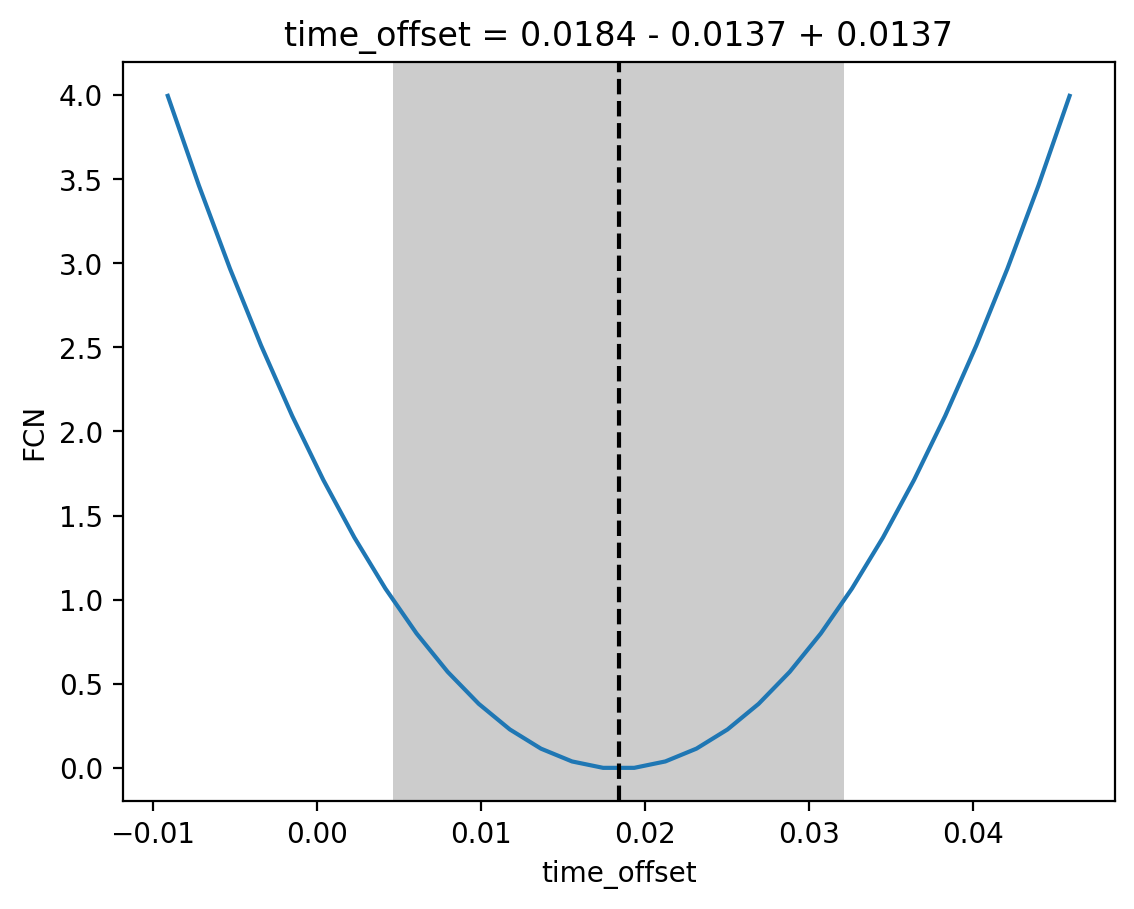

In [17]:
#m.draw_profile("time_offset"); 
#m.draw_profile("orbit_offset");

m.draw_mnprofile("time_offset");
#m.draw_mnprofile("orbit_offset");
#m.draw_mncontour("time_offset", "orbit_offset", cl=(1, 2), experimental=False);

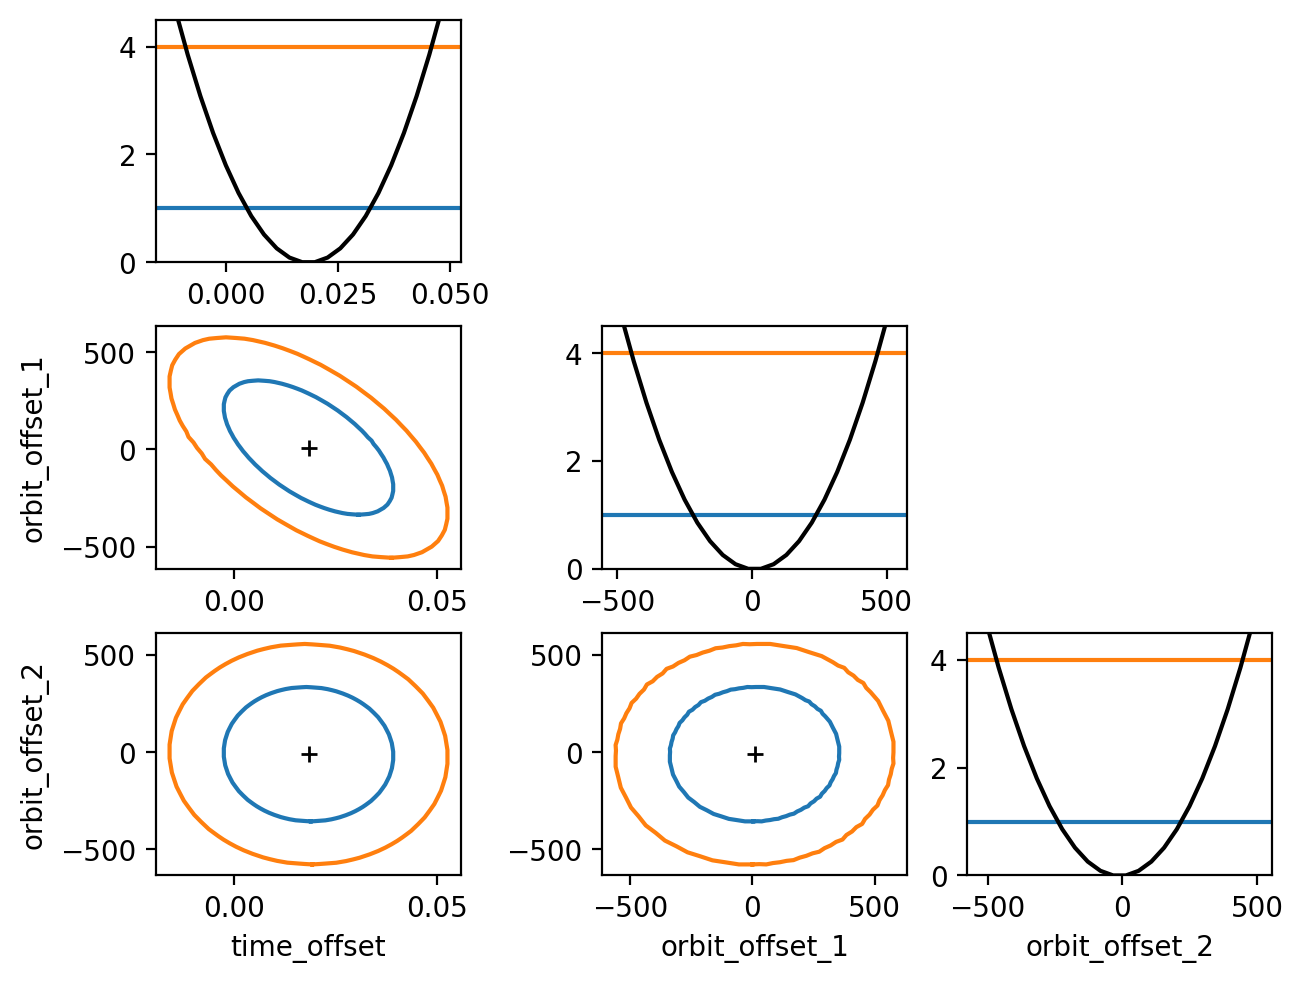

In [18]:
m.draw_mnmatrix(cl=(1, 2));

In [19]:
%%script echo skip cell
#m.draw_contour("time_offset", "orbit_offset", bound=[[-.08,.10],[-2000, 2000]]);

x,y,z, = m.contour("time_offset", "orbit_offset", subtract_min=True, bound=[[-.10,.12],[-2500, 2500]])
plt.contour(x, y, z, (2.3, 6.18))

skip cell
